# Analysis of Predictions Produced with Chunks

This script analyzes all pickle files in `./data/darts/{n_chunks}_chunks/`, starting with `confusion_matrix`, i.e. all model-level and all chunk-level matrices. At the moment, the paths are adapted for local execution.

## Analysis of Model-level Matrices

### Extract All Generated Model-level Matrices

In [1]:
import os
import pandas as pd
import pickle5 as pickle

# Define number of chunks taken to adjust
n_chunks = 1000

# Define path to all model-level matrices produced by prediction
path_to_model_matrices = f'../../data/darts/{n_chunks}_chunks'

# Collect pickle file names of model-level matrices
model_matrix_filenames = list()

for file in os.listdir(path_to_model_matrices):
    if os.path.isfile(os.path.join(path_to_model_matrices, file)) and \
            file.startswith('confusion_matrix_models') and file.endswith('.pickle'):
        model_matrix_filenames.append(file)

# Concat all found matrices into result matrix
result_matrix_models = pd.DataFrame(columns=['ID', 'PARAMETER', 'MODEL', 'ENDOGENOUS', 'EXOGENOUS', 'FORECAST_TYPE',
                                             'FIRST_FORECAST', 'ALARM_TYPE', 'FP', 'TP', 'FN', 'TN', 'N_CHUNKS',
                                             'N_ITERATIONS'])

for filename in model_matrix_filenames:
    # Read file
    current_matrix_f = open(f'{path_to_model_matrices}/{filename}', 'rb')
    current_matrix = pickle.load(current_matrix_f)
    current_matrix_f.close()

    # Append current matrix to result matrix
    result_matrix_models = pd.concat([result_matrix_models, current_matrix])

# Sort result matrix for better readability
result_matrix_models.sort_values(by=['PARAMETER', 'MODEL', 'ENDOGENOUS'], inplace=True)

# Show result matrix
print(result_matrix_models)

          ID PARAMETER MODEL ENDOGENOUS EXOGENOUS FORECAST_TYPE  \
1  BP_R_02_H        BP   GRU        MAX    MEDIAN     Expanding   
1  BP_R_01_B        BP   GRU     MEDIAN       n/a     Expanding   
1  BP_R_03_L        BP   GRU        MIN    MEDIAN     Expanding   
1  BP_R_02_H        BP  LSTM        MAX    MEDIAN     Expanding   
1  BP_R_01_B        BP  LSTM     MEDIAN       n/a     Expanding   
1  BP_R_03_L        BP  LSTM        MIN    MEDIAN     Expanding   
1  BP_R_02_H        BP   RNN        MAX    MEDIAN     Expanding   
1  BP_R_01_B        BP   RNN     MEDIAN       n/a     Expanding   
1  BP_R_03_L        BP   RNN        MIN    MEDIAN     Expanding   
0  HR_R_02_H        HR   GRU        MAX    MEDIAN     Expanding   
0  HR_R_01_B        HR   GRU     MEDIAN       n/a     Expanding   
0  HR_R_03_L        HR   GRU        MIN    MEDIAN     Expanding   
0  HR_R_02_H        HR  LSTM        MAX    MEDIAN     Expanding   
0  HR_R_01_B        HR  LSTM     MEDIAN       n/a     Expandin

### Add Accuracy Metrics and Save as Parquet File

In [2]:
# Calculate metrics (see https://en.wikipedia.org/wiki/Sensitivity_and_specificity for more information)
result_matrix_models['FPR'] = result_matrix_models['FP'] / (result_matrix_models['FP'] + result_matrix_models['TN'])
result_matrix_models['TPR'] = result_matrix_models['TP'] / (result_matrix_models['TP'] + result_matrix_models['FN'])
result_matrix_models['FNR'] = result_matrix_models['FN'] / (result_matrix_models['TP'] + result_matrix_models['FN'])
result_matrix_models['TNR'] = result_matrix_models['TN'] / (result_matrix_models['FP'] + result_matrix_models['TN'])

result_matrix_models['ACC'] = (result_matrix_models['TP'] + result_matrix_models['TN']) / \
                              (result_matrix_models['TP'] + result_matrix_models['FN'] + result_matrix_models['FP'] + result_matrix_models['TN'])
result_matrix_models['F1S'] = result_matrix_models['TP'] / \
                              (result_matrix_models['TP'] + 0.5 * (result_matrix_models['FP'] + result_matrix_models['FN']))

# Round all floats to 4 decimal places
# Note: round() does not work for floats with many decimal places
decimals = 4
for col in ['FPR', 'TPR', 'FNR', 'TNR', 'ACC', 'F1S']:
    result_matrix_models[col] = result_matrix_models[col].apply(lambda x: round(x, decimals))

# Move cols to end for similarity with ARIMA results and reset index
result_matrix_models = result_matrix_models[['ID', 'PARAMETER', 'MODEL', 'ENDOGENOUS', 'EXOGENOUS', 'FORECAST_TYPE',
                                             'FIRST_FORECAST', 'ALARM_TYPE', 'FP', 'TP', 'FN', 'TN', 'FPR', 'TPR',
                                             'FNR', 'TNR', 'ACC', 'F1S', 'N_CHUNKS', 'N_ITERATIONS']].reset_index(drop=True)

# Show complemented result matrix
print(result_matrix_models)

# Save result matrix as parquet
result_matrix_models.to_parquet('../../data/darts/1000_chunks/result_matrix_models.parquet', engine='pyarrow')

           ID PARAMETER MODEL ENDOGENOUS EXOGENOUS FORECAST_TYPE  \
0   BP_R_02_H        BP   GRU        MAX    MEDIAN     Expanding   
1   BP_R_01_B        BP   GRU     MEDIAN       n/a     Expanding   
2   BP_R_03_L        BP   GRU        MIN    MEDIAN     Expanding   
3   BP_R_02_H        BP  LSTM        MAX    MEDIAN     Expanding   
4   BP_R_01_B        BP  LSTM     MEDIAN       n/a     Expanding   
5   BP_R_03_L        BP  LSTM        MIN    MEDIAN     Expanding   
6   BP_R_02_H        BP   RNN        MAX    MEDIAN     Expanding   
7   BP_R_01_B        BP   RNN     MEDIAN       n/a     Expanding   
8   BP_R_03_L        BP   RNN        MIN    MEDIAN     Expanding   
9   HR_R_02_H        HR   GRU        MAX    MEDIAN     Expanding   
10  HR_R_01_B        HR   GRU     MEDIAN       n/a     Expanding   
11  HR_R_03_L        HR   GRU        MIN    MEDIAN     Expanding   
12  HR_R_02_H        HR  LSTM        MAX    MEDIAN     Expanding   
13  HR_R_01_B        HR  LSTM     MEDIAN       n

### Plot Ratios

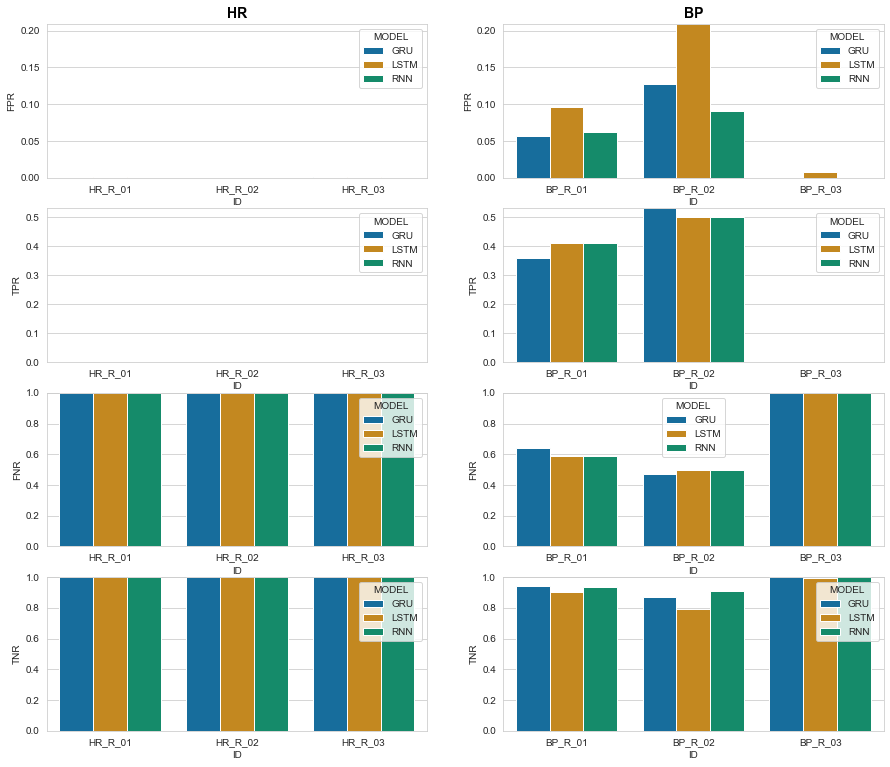

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# "Group" result matrix by prefix of ID
plotdata = result_matrix_models.replace(['_H', '_L', '_B'], ['', '', ''], regex=True)

# Create subplots
sns.set_style('whitegrid')
fig, axs = plt.subplots(
    nrows=4,
    ncols=2, # TODO: adjust if O2 is added
    figsize=(15, 13),
    dpi=72
    )

# Define y-limits
fpr_ylimits = [0, max(result_matrix_models.FPR)]
tpr_ylimits = [0, max(result_matrix_models.TPR)]
fnr_ylimits = [0, max(result_matrix_models.FNR)]
tnr_ylimits = [0, max(result_matrix_models.TNR)]

# Actual plots
# TODO: execute again with O2
for i, parameter in enumerate(['HR', 'BP']):
    sns.barplot(
        ax=axs[0, i],
        data=plotdata[plotdata.PARAMETER == parameter],
        x='ID',
        y='FPR',
        hue='MODEL',
        palette=sns.color_palette('colorblind'),
        ci=None,
        order=[f'{parameter}_R_01', f'{parameter}_R_02', f'{parameter}_R_03'])
    axs[0, i].set_title(str(parameter), fontweight='bold', color= 'black', fontsize=14)
    axs[0, i].set_ylim(fpr_ylimits)

    sns.barplot(
        ax=axs[1, i],
        data=plotdata[plotdata.PARAMETER == parameter],
        x='ID',
        y='TPR',
        hue='MODEL',
        palette=sns.color_palette('colorblind'),
        ci=None,
        order=[f'{parameter}_R_01', f'{parameter}_R_02', f'{parameter}_R_03'])
    axs[1, i].set_ylim(tpr_ylimits)

    sns.barplot(
        ax=axs[2, i],
        data=plotdata[plotdata.PARAMETER == parameter],
        x='ID',
        y='FNR',
        hue='MODEL',
        palette=sns.color_palette('colorblind'),
        ci=None,
        order=[f'{parameter}_R_01', f'{parameter}_R_02', f'{parameter}_R_03'])
    axs[2, i].set_ylim(fnr_ylimits)

    sns.barplot(
        ax = axs[3, i],
        data = plotdata[plotdata.PARAMETER == parameter],
        x='ID',
        y='TNR',
        hue='MODEL',
        palette = sns.color_palette('colorblind'),
        ci=None,
        order=[f'{parameter}_R_01', f'{parameter}_R_02', f'{parameter}_R_03'])
    axs[3, i].set_ylim(tnr_ylimits)

#plt.show(fig)
fig.savefig(f'../../plots/darts/{n_chunks}_chunks/ratios_model_result_matrix.png', dpi=1200)

### Plot Accuracy and F1 Score

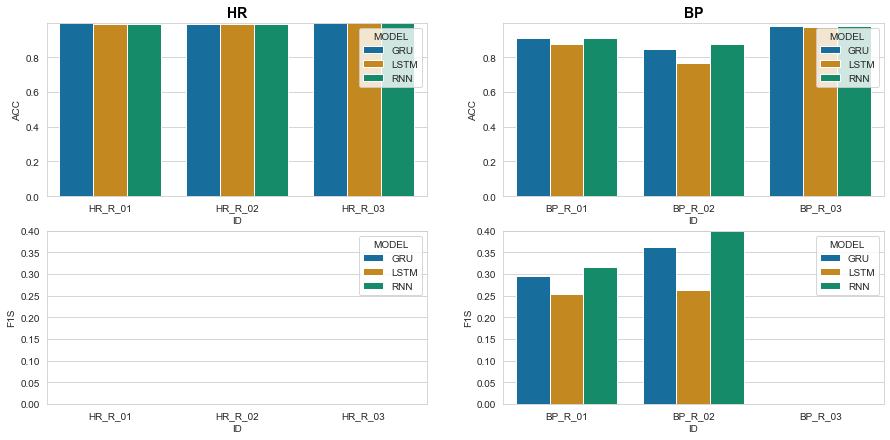

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# "Group" result matrix by prefix of ID
plotdata = result_matrix_models.replace(['_H', '_L', '_B'], ['', '', ''], regex=True)

# Create subplots
sns.set_style('whitegrid')
fig, axs = plt.subplots(
    nrows=2,
    ncols=2, # TODO: adjust if O2 is added
    figsize=(15, 7),
    dpi=72
    )

# Define y-limits
acc_ylimits = [0, max(result_matrix_models.ACC)]
f1s_ylimits = [0, max(result_matrix_models.F1S)]

# Actual plot
# TODO: execute again with O2
for i, parameter in enumerate(['HR', 'BP']):

    sns.barplot(
        ax=axs[0, i],
        data=plotdata[plotdata.PARAMETER == parameter],
        x='ID',
        y='ACC',
        hue='MODEL',
        palette=sns.color_palette('colorblind'),
        ci=None,
        order=[f'{parameter}_R_01', f'{parameter}_R_02', f'{parameter}_R_03'])
    axs[0, i].set_title(str(parameter), fontweight='bold', color= 'black', fontsize=14)
    axs[0, i].set_ylim(acc_ylimits)

    sns.barplot(
        ax=axs[1, i],
        data=plotdata[plotdata.PARAMETER == parameter],
        x='ID',
        y='F1S',
        hue='MODEL',
        palette=sns.color_palette('colorblind'),
        ci=None,
        order=[f'{parameter}_R_01', f'{parameter}_R_02', f'{parameter}_R_03'])
    axs[1, i].set_ylim(f1s_ylimits)

#plt.show(fig)
fig.savefig(f'../../plots/darts/{n_chunks}_chunks/acc_f1s_model_result_matrix.png', dpi=1200)

## Analysis of Chunk-level Matrices

### Print Results of Selected Chunk/s

In [5]:
import pickle5 as pickle

# TODO: as soon as we decided for a uniform layout, complement chunk-level matrices

# => Proposal: change
#              ['CHUNK_ID', 'ALARM_TYPE', 'N_ITERATIONS', 'FP', 'TP', 'FN', 'TN']
#              to
#              ['CHUNK_ID', 'PARAMETER', 'MODEL', 'ENDOGENOUS', 'EXOGENOUS', 'FORECAST_TYPE', 'FIRST_FORECAST',
#               'ALARM_TYPE', 'FP', 'TP', 'FN', 'TN', 'N_ITERATIONS']
#              and insert metrics in analysis script

# Define parameters to adjust
n_chunks = 1000
model_type = 'RNN'
parameter = 'hr'
endogenous_input = 'MEDIAN'

# Define path to all chunk-level matrices produced by prediction
path_to_chunk_matrices = f'../../data/darts/{n_chunks}_chunks'

# Read chunk-specific matrix
chunks_matrix_f = open(f'{path_to_chunk_matrices}/confusion_matrix_chunks_{model_type}_{parameter}_{endogenous_input}.pickle', 'rb')
chunks_matrix = pickle.load(chunks_matrix_f)
chunks_matrix_f.close()

# Show chunk-specific matrix
#print(chunks_matrix)

# Show one chunk result
print(chunks_matrix[chunks_matrix['CHUNK_ID'] == '200033.0_220045.0_2198-08-07 19:53:00'])

                                 CHUNK_ID ALARM_TYPE N_ITERATIONS FP TP FN  TN
16  200033.0_220045.0_2198-08-07 19:53:00       High           18  0  0  0  18
17  200033.0_220045.0_2198-08-07 19:53:00        Low           18  0  0  5  13


### Plot Correlation Between Chunk Length and Chunk Accuracy

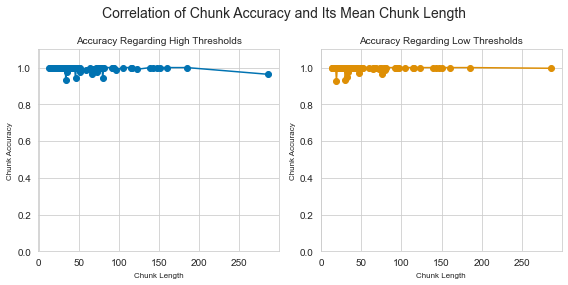

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define input length to adjust
input_length = 12

# Add accuracy column to all chunks of matrix
chunks_matrix['ACC'] = (chunks_matrix['TP'] + chunks_matrix['TN']) / \
                      (chunks_matrix['TP'] + chunks_matrix['FN'] + chunks_matrix['FP'] + chunks_matrix['TN'])

# Add column for chunk length to all chunks of matrix
chunks_matrix['LENGTH'] = chunks_matrix['N_ITERATIONS'] + input_length

# Extract chunks for high and low analysis plot
high_chunks = chunks_matrix[chunks_matrix['ALARM_TYPE'] == 'High'][['ACC', 'LENGTH']]
low_chunks = chunks_matrix[chunks_matrix['ALARM_TYPE'] == 'Low'][['ACC', 'LENGTH']]

# Introduce mean value for each length
high_chunks_prep = high_chunks.astype(float)
high_chunks_prep = high_chunks_prep.groupby('LENGTH').mean()

low_chunks_prep = low_chunks.astype(float)
low_chunks_prep = low_chunks_prep.groupby('LENGTH').mean()

# Reset indices to make access via column names possible again
high_chunks_prep.reset_index(level=0, inplace=True)
low_chunks_prep.reset_index(level=0, inplace=True)

# Define background color, subplots and suptitle
sns.set_style('whitegrid')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
fig.suptitle('Correlation of Chunk Accuracy and Its Mean Chunk Length', fontsize=14)

if endogenous_input == 'MIN':
    ax1.set_visible(False)
    ax2.set_position([1, 0.2, 0.05, 0.2])
else:
    # Add left plot (high threshold analysis)
    ax1.plot('LENGTH', 'ACC', data=high_chunks_prep, marker='o', color=sns.color_palette('colorblind')[0])
    ax1.set_title('Accuracy Regarding High Thresholds', fontsize=10)
    ax1.set_xlabel('Chunk Length', fontsize=8)
    ax1.set_ylabel('Chunk Accuracy', fontsize=8)
    ax1.set_ylim(bottom=0, top=1.1)

if endogenous_input == 'MAX':
    ax2.set_visible(False)
    ax1.set_position([0, 0.2, 0.05, 0.2])
else:
    # Add right plot (low threshold analysis)
    ax2.plot('LENGTH', 'ACC', data=low_chunks_prep, marker='o', color=sns.color_palette('colorblind')[1])
    ax2.set_title('Accuracy Regarding Low Thresholds', fontsize=10)
    ax2.set_xlabel('Chunk Length', fontsize=8)
    ax2.set_ylabel('Chunk Accuracy', fontsize=8)
    ax2.set_ylim(bottom=0, top=1.1)

# Improve layout and save figure
fig.tight_layout()
#fig.show()
fig.savefig(f'../../plots/darts/{n_chunks}_chunks/correlation_chunk_length_and_accuracy_{model_type}_{parameter}_{endogenous_input}.png', dpi=1200)

### Time-Series Plot of Chunk with Prediction

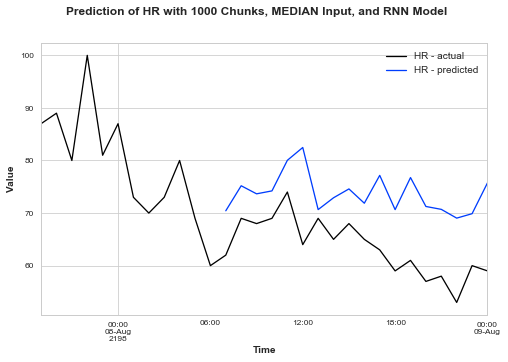

In [7]:
from darts import TimeSeries

chunk_id = '200033.0_220045.0_2198-08-07 19:53:00'
chunk_id_windows = chunk_id.replace(':', '%3A')  # have to be used when loading from or saving to Windows machine

# Extract predicted series of chunk
prediction_chunk_f = open(f'../../data/darts/{n_chunks}_chunks/{model_type}/{parameter}/{endogenous_input}/'
                          f'05_prediction_{chunk_id_windows}.pickle', 'rb')
prediction_chunk = pickle.load(prediction_chunk_f)
prediction_chunk_f.close()

# Convert predicted series of chunk to TimeSeries object
prediction_chunk = TimeSeries.from_dataframe(
    df=prediction_chunk,
    time_col='Time',
    value_cols=['Value'],
    freq='H')

# Extract original series of chunk
resampled_chunks = pd.read_parquet(f'../../data/resampling/resample_output_{parameter}_first{n_chunks}.parquet', engine='pyarrow')
original_chunk = resampled_chunks[resampled_chunks['CHUNK_ID_FILLED_TH'] == chunk_id]

# Convert original series of chunk to TimeSeries object
original_chunk = TimeSeries.from_dataframe(
    df=original_chunk,
    time_col='CHARTTIME',
    value_cols=[f'VITAL_PARAMTER_VALUE_{endogenous_input}_RESAMPLING'],
    freq='H')

# Actual plot
sns.set_style('whitegrid')
plt.figure(figsize=(8, 5))
original_chunk.plot(label=f'{parameter.upper()} - actual')
prediction_chunk.plot(label=f'{parameter.upper()} - predicted')

# Adjust texts of plot
plt.legend()
plt.suptitle(f'Prediction of {parameter.upper()} with {n_chunks} Chunks, {endogenous_input} Input, and {model_type} Model', fontweight='bold')
plt.xlabel('Time')
plt.ylabel('Value')

#plt.show()
plt.savefig(f'../../plots/darts/{n_chunks}_chunks/prediction_{model_type}_{parameter}_{endogenous_input}_{chunk_id_windows}.png', dpi=1200)